# 1. Read in data.

In [31]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 54.3 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta

In [16]:
# Run generate_health_data.py and read in datasets

df_baseline = pd.read_csv("patient_baseline.csv", sep = '\t')
df_longitudinal = pd.read_csv("patient_longitudinal.csv", sep = '\t')
df_treatment = pd.read_csv("patient_treatment.csv", sep = '\t')

df_baseline.head()

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3
1,1,47.9,0,23.2,0,0,149.4,155.9,75.4
2,2,59.7,1,29.0,0,0,136.7,220.7,85.0
3,3,72.8,1,34.6,0,1,141.0,205.7,78.0
4,4,46.5,0,17.5,0,0,129.0,186.8,95.2


# 2. Time Series Tasks

## 1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values

In [17]:
# Convert `visit_date` to datetime
df_longitudinal['visit_date'] = pd.to_datetime(df_longitudinal['visit_date'], format='%Y-%m-%d')

# Sort values by `patient_id` and `visit_date` for consistency
df_longitudinal = df_longitudinal.sort_values(by=['patient_id', 'visit_date'])

# Remove duplicates by averaging duplicated entries per `patient_id` and `visit_date`
df_longitudinal = df_longitudinal.groupby(['patient_id', 'visit_date']).agg({
    'bp_systolic': 'mean',
    'heart_rate': 'mean',
    'adverse_event': 'max',  # 1 if patient ever experienced cardiovascular event
    'age': 'first',
    'sex': 'first',
    'bmi': 'first',
    'smoking': 'first',
    'diabetes': 'first'
}).reset_index()

# Set up the DatetimeIndex and fill any missing values by interpolation
df_longitudinal.set_index('visit_date', inplace=True)

# Interpolate all numeric columns for missing values
df_longitudinal.interpolate(method='linear', inplace=True)

In [ ]:
# Check for missing values
print(df_longitudinal.isnull().sum())

df_longitudinal.head()

patient_id       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64


,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2023-01-17,0,111.0,78.7,0,57.5,0.0,25.8,0.0,0.0
2023-09-23,0,112.0,79.5,0,57.5,0.0,25.8,0.0,0.0
2024-05-22,0,111.2,78.7,0,57.5,0.0,25.8,0.0,0.0
2024-12-31,0,109.2,79.5,0,57.5,0.0,25.8,0.0,0.0
2023-01-17,1,146.1,78.9,0,47.9,0.0,23.2,0.0,0.0


## 2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

In [25]:
# Resample to monthly frequency using mean aggregation
df_monthly = df_longitudinal['bp_systolic'].resample('ME').mean() # 'M' is deprecated, use 'ME'

# df_monthly.head()

# Interpolate missing values (if any) after resampling
df_monthly = df_monthly.interpolate()

# Calculate the 3-month moving average, set min_periods
df_monthly_smoothed = df_monthly.rolling(window=3, min_periods=1).mean()

# Calculate exponential weighted moving average (EWMA) for smoother trends
df_monthly_ewm = df_monthly.ewm(span=3, adjust=False).mean()

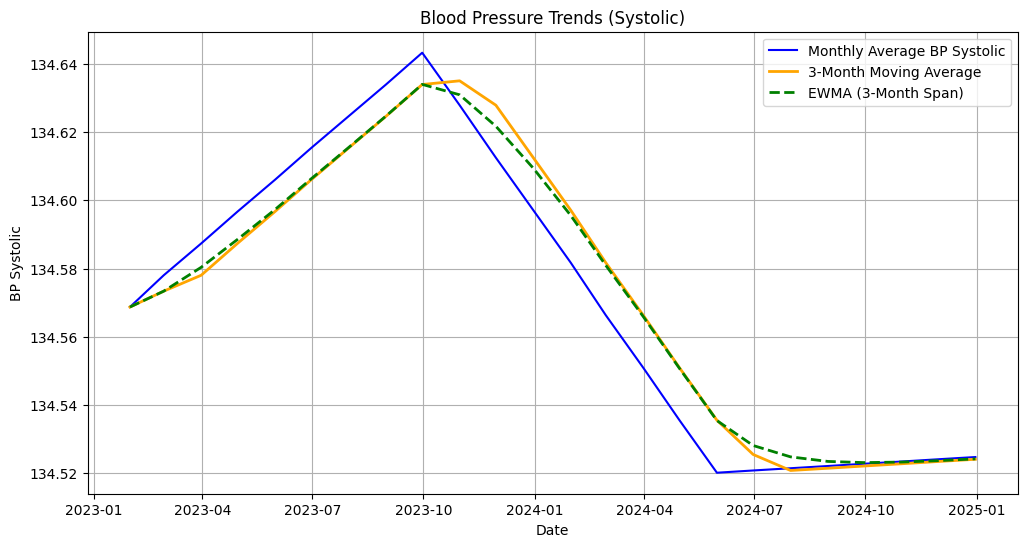

In [26]:
# Plotting the original and smoothed trends
plt.figure(figsize=(12, 6))

# Plot original monthly resampled data
plt.plot(df_monthly, label='Monthly Average BP Systolic', color='blue', linewidth=1.5)

# Plot 3-month moving average
plt.plot(df_monthly_smoothed, label='3-Month Moving Average', color='orange', linewidth=2)

# Plot Exponentially Weighted Moving Average (EWMA)
plt.plot(df_monthly_ewm, label='EWMA (3-Month Span)', color='green', linestyle='--', linewidth=2)

# Labels and legend
plt.title('Blood Pressure Trends (Systolic)')
plt.xlabel('Date')
plt.ylabel('BP Systolic')
plt.legend()
plt.grid()

# Display the plot
plt.show()

# Statistical Modeling Tasks

## 1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

In [35]:
# Selecting baseline (first visit) data for each patient
baseline_data = df_longitudinal.groupby('patient_id').first()

# Prepare feature matrix X and target variable y
X = baseline_data[['age', 'bmi', 'smoking', 'diabetes']]
y = baseline_data['bp_systolic']

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit(cov_type='HC3')  # HC3 for robust standard errors

# Display model summary for coefficients, p-values, and R-squared
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     140.0
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           6.32e-95
Time:                        20:28:21   Log-Likelihood:                -3725.0
No. Observations:                1000   AIC:                             7460.
Df Residuals:                     995   BIC:                             7485.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.7288      2.041     53.285      0.0

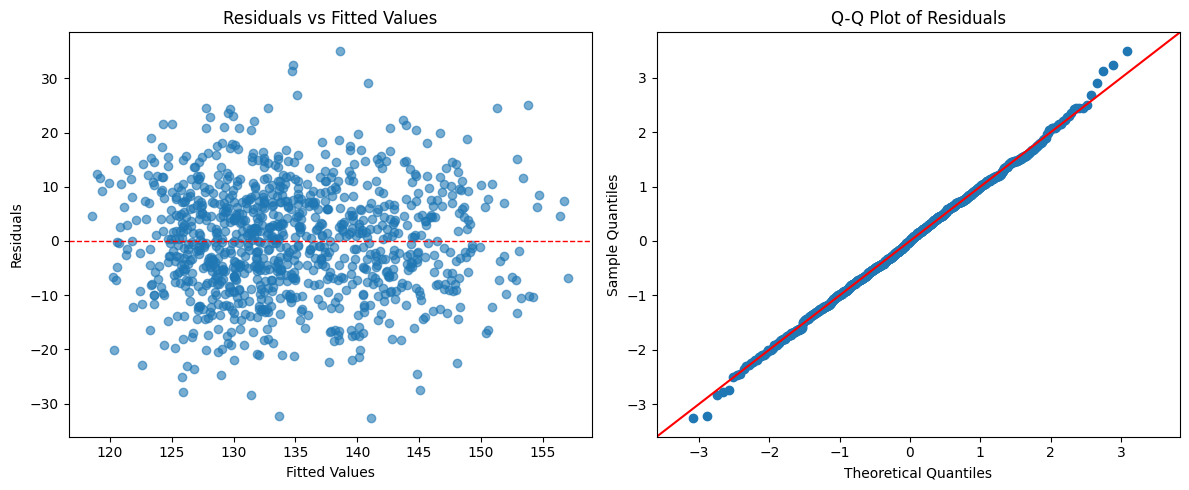

In [36]:
# Residuals vs Fitted Values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

# Q-Q Plot for Normality of Residuals
plt.subplot(1, 2, 2)
sm.qqplot(model.resid, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

### Interpretation of findings.

My regression analysis results in a fairly strong model, with several statistically significant predictors for bp_systolic based on age, bmi, smoking, and diabetes. 

The r-squared for my model is 0.363. This indicates that approximately 36.3% of the variance in bp_systolic is explained by the predictors. While this suggests a moderate level of explanatory power, it implies that additional factors beyond those included in the model may be influencing blood pressure. 

The adjusted r-squared is 0.361 is very close to the r-squared value. The adjusted r-squared accounts for the number of predictors in the model. This indicates that the predictors are indeed contributing useful information to the model, and the model is not overfitting.

The F-statistic of 140.0 and the associated very low p-value (6.32e-95) suggest that the overall model is highly statistically significant. This indicates that at least one of the predictors is significantly associated with bp_systolic.

Each predictor has a significant association with bp_systolic.

The coefficient for age is 0.285, suggesting that each additional year in age is associated with an increase of approximately 0.285 mmHg in systolic blood pressure, holding other variables constant. This positive association is statistically significant (p < 0.05), reflecting that age is an important factor in blood pressure.

The coefficient for BMI is 0.270. This means each unit increase in BMI is associated with an increase of approximately 0.27 mmHg in blood pressure. This also is statistically significant, underscoring BMI's influence on blood pressure.

The coefficient for smoking is 5.088. Smokers are associated with a 5.088 mmHg higher systolic blood pressure on average compared to non-smokers, holding other factors constant. This is a meaningful increase, reinforcing the known link between smoking and increased blood pressure.

The coefficient for diabetes is 9.847. Being diabetic is associated with a 9.847 mmHg increase in systolic blood pressure on average, a large and statistically significant effect. This finding aligns with clinical observations that diabetes is a key risk factor for higher blood pressure.

The residuals vs. fitted values plot shows a random scatter of points around zero, indicating that the model's residuals are homoscedastic (i.e., constant variance across fitted values). This supports the assumption that the model's variance is stable across predictions, which is important for accurate standard error estimates.

The Q-Q plot shows residuals following the line closely, suggesting that the residuals are normally distributed. This is a good sign, as it validates the model’s assumption of normally distributed errors.

## 2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations

In [38]:
df_treatment.head()

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate,treatment,adherence,outcome
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3,0,0.67,1
1,1,47.9,0,23.2,0,0,149.4,155.9,75.4,1,0.90,1
2,2,59.7,1,29.0,0,0,136.7,220.7,85.0,0,0.74,0
3,3,72.8,1,34.6,0,1,141.0,205.7,78.0,1,0.70,1
4,4,46.5,0,17.5,0,0,129.0,186.8,95.2,0,0.77,0


In [40]:
# Prepare the feature matrix X and target variable y
X2 = df_treatment[['age', 'sex', 'bmi', 'smoking', 'diabetes', 'bp_systolic', 'cholesterol', 'heart_rate', 'adherence']]
y2 = df_treatment['outcome']

# Add a constant term to the predictor variables
X2 = sm.add_constant(X2)

# Fit the GLM model with a binomial family
model2 = sm.GLM(y2, X2, family=sm.families.Binomial()).fit()

# Calculate odds ratios and 95% confidence intervals
odds_ratios = np.exp(model2.params)
conf = model2.conf_int()
conf_odds_ratios = np.exp(conf)
conf_odds_ratios.columns = ['2.5%', '97.5%']

# Combine odds ratios and confidence intervals for interpretation
odds_ratios_summary = pd.DataFrame({'Odds Ratio': odds_ratios, '2.5%': conf_odds_ratios['2.5%'], '97.5%': conf_odds_ratios['97.5%']})
print("Odds Ratios with 95% Confidence Intervals:")
print(odds_ratios_summary)

# Step 4: Assess model fit by examining deviance
# Residual Deviance vs Null Deviance
print("\nModel Fit Assessment:")
print("Null Deviance:", model2.null_deviance)
print("Residual Deviance:", model2.deviance)
print("Degrees of Freedom:", model2.df_resid)

Odds Ratios with 95% Confidence Intervals:
             Odds Ratio      2.5%      97.5%
const          0.013070  0.001121   0.152422
age            1.001881  0.991077   1.012804
sex            0.925642  0.711743   1.203824
bmi            0.992188  0.964346   1.020834
smoking        0.768155  0.500439   1.179089
diabetes       0.572442  0.395157   0.829265
bp_systolic    1.017250  1.003693   1.030990
cholesterol    1.006231  0.999717   1.012787
heart_rate     0.990072  0.977849   1.002448
adherence      7.404862  1.978332  27.716269

Model Fit Assessment:
Null Deviance: 1334.774434101428
Residual Deviance: 1284.4462321365681
Degrees of Freedom: 990


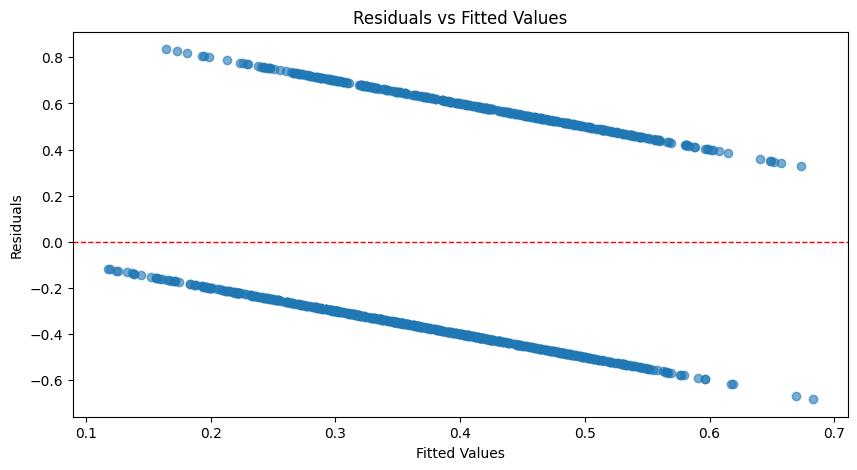

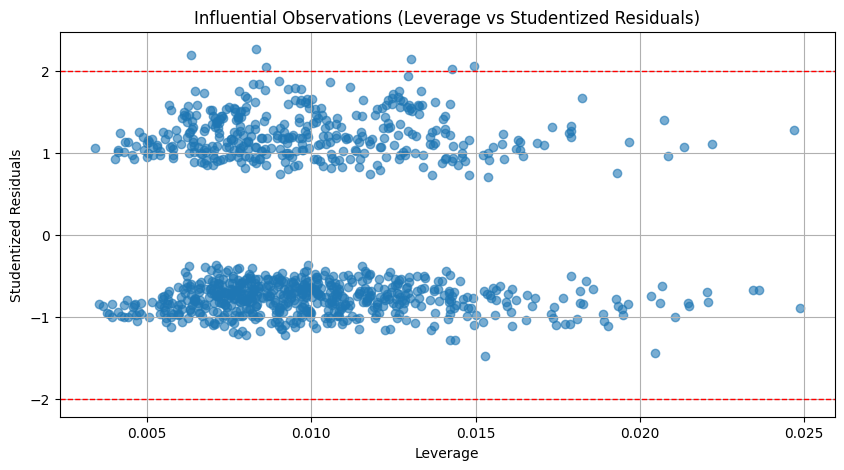

In [42]:
# Diagnostic Plot: Residuals vs Fitted values
plt.figure(figsize=(10, 5))
plt.scatter(model2.fittedvalues, model2.resid_response, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Step 5: Check for influential observations
influence = model2.get_influence()
leverage = influence.hat_matrix_diag
residuals_studentized = influence.resid_studentized

# Plot influential points
plt.figure(figsize=(10, 5))
plt.scatter(leverage, residuals_studentized, alpha=0.6)
plt.xlabel("Leverage")
plt.ylabel("Studentized Residuals")
plt.title("Influential Observations (Leverage vs Studentized Residuals)")
plt.axhline(-2, linestyle='--', color='red', linewidth=1)
plt.axhline(2, linestyle='--', color='red', linewidth=1)
plt.grid()
plt.show()

### Interpretation of findings.

Odds Ratios Interpretation
Constant (Intercept):

The constant (intercept) has an odds ratio of 0.0131. This means that the odds of treatment success when all predictors are zero are very low. This value is less meaningful in practical terms, as it generally represents a baseline and is often not directly interpretable. Also, if all predictors are zero, it could mean that the patient doesn't require treatment either (for example, they do not have diabetes).

For each additional year of age, the odds of treatment success increase by approximately 0.19%. However, the confidence interval includes 1, indicating this effect may not be statistically significant.

Sex = 1 decreases the odds of treatment success by about 7.4%, but again, this confidence interval includes 1, suggesting no significant effect.

A one-unit increase in BMI is associated with a 0.78% decrease in odds of treatment success. The confidence interval is close to 1, indicating the effect may not be significant.

Smokers are associated with a 23.2% decrease in odds of treatment success, but the confidence interval suggests this may not be statistically significant.
Diabetes:

Individuals with diabetes have about 42.8% lower odds of treatment success compared to those without diabetes. This effect is statistically significant since the confidence interval does not include 1.

For every unit increase in systolic blood pressure, the odds of treatment success increase by approximately 1.73%, which is statistically significant given that the confidence interval does not include 1.

Each unit increase in cholesterol is associated with a 0.62% increase in odds of treatment success, but the confidence interval indicates this effect is marginal.

An increase in heart rate is associated with a 0.99% decrease in odds of treatment success, with the confidence interval suggesting no significant effect.

For each percentage increase in adherence to the treatment, the odds of treatment success increase by approximately 640.49%. This is highly statistically significant since the confidence interval does not include 1, suggesting that adherence is a strong predictor of treatment success.

Null Deviance: 1334.77
Residual Deviance: 1284.45
Degrees of Freedom: 990

The drop in deviance from the null model to the fitted model indicates that the predictors improve the model fit. A significant reduction in deviance suggests that the model explains the data better than a model with just an intercept. The model is reasonably good, but assessing the fit further using plots is important.

The leverage vs studentized residual plot shows the leverage (influence on the fitted model) of each observation against the studentized residuals (standardized measure of residuals). The points are relatively evenly distributed between positive and negative studentized residuals, and no individual points are excessively far from the center horizontally. This suggests no major leverage issues for individual observations. A few points lie close to the horizontal red lines at +2 or -2, which are threshold lines indicating where residuals become unusually high or low. However, most observations fall well within this range, indicating that the model has relatively few outliers.
The two clusters of points suggest some structure in the residuals, which could imply that some groups of patients (likely those with similar baseline characteristics) share residual characteristics. Overall, there are no major influential outliers that might be distorting the model, but the clustering may indicate underlying patterns not fully captured by the current model.

The residuals vs. fitted values plot displays residuals on the y-axis against the fitted values (predicted probabilities) on the x-axis. The two parallel, decreasing bands suggest a pattern in the residuals where observations either cluster around a high or low residual band. Ideally, residuals should be randomly scattered around zero without any discernible pattern. Here, the parallel lines indicate that the model is not capturing some aspects of the data structure, possibly due to underlying categorical or grouped effects that were not accounted for. The clear separation into two bands might be related to the binary nature of the outcome variable, where one band could represent cases that achieved the treatment goal and the other those that did not.